In [5]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

import warnings
import numpy as np
from collections import OrderedDict

import os

from lob_data_utils import lob, db_result, gdf_pca, model
from lob_data_utils.svm_calculation import lob_svm


sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

In [28]:
data_length = 15000
stocks = ['9064', '9061', '9265']
gdf_filename_pattern = 'gdf_{}_' + 'len{}'.format(data_length) + '_r{}_s{}_K50'
gdf_parameters = [(1.0, 1.0), (0.1, 0.1), (0.1, 1.0), (1.0, 0.1), (0.01, 0.1)]
should_save_fig = False

In [7]:
gdf_dfs = {}
for stock in stocks:
    gdf_dfs[stock] = []
    for r, s in gdf_parameters:
        gdf_dfs[stock].append(gdf_pca.SvmGdfResults(
            stock,  r=r, s=s, data_length=data_length, 
            gdf_filename_pattern=gdf_filename_pattern))

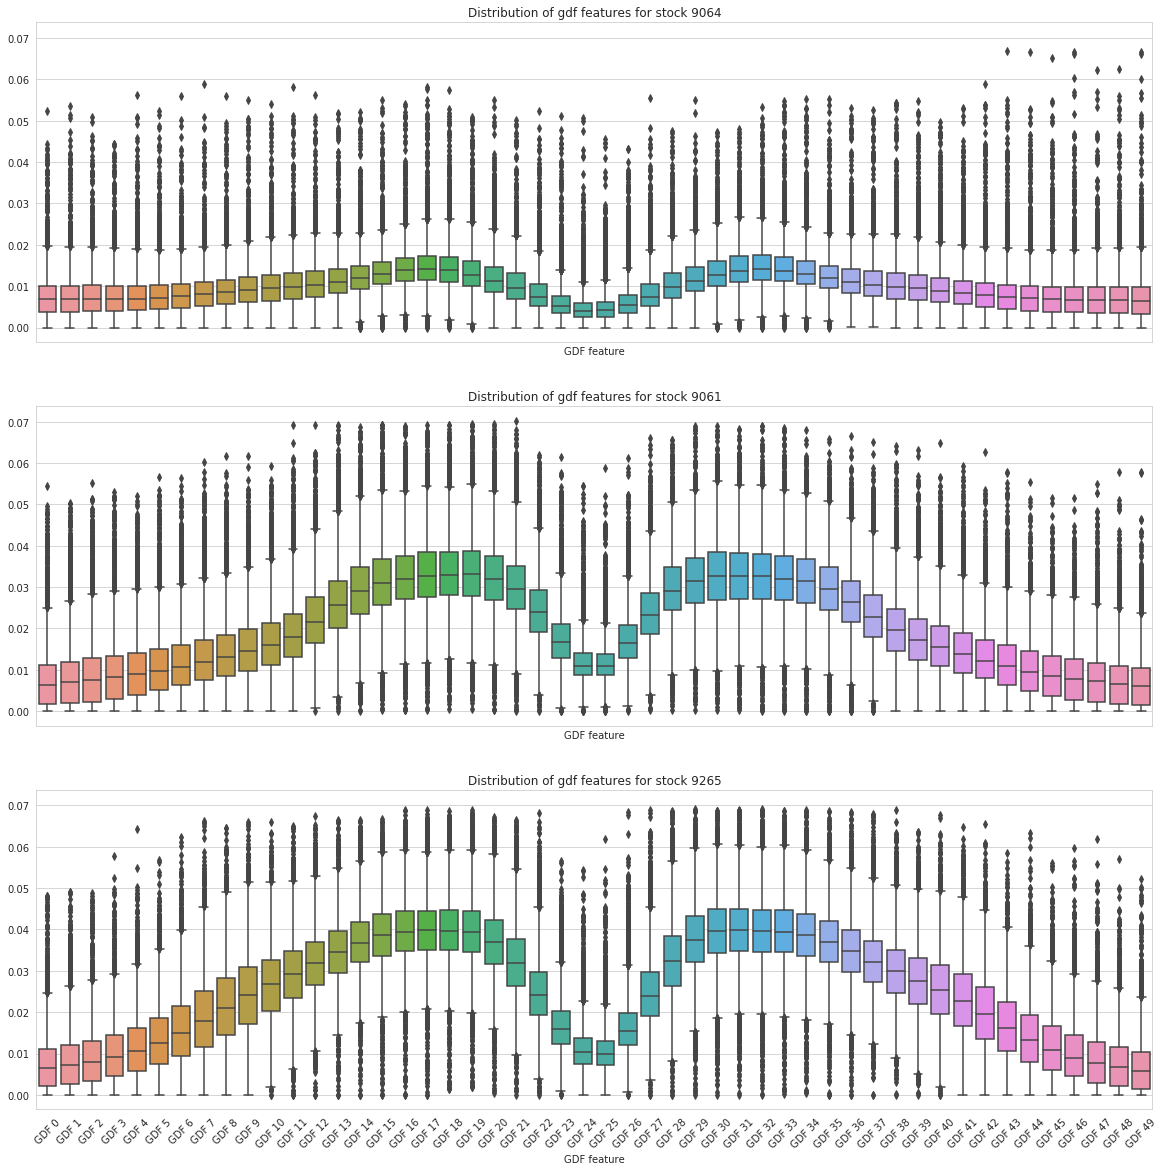

In [29]:
gdf_columns = ['gdf_' + str(i) for i in range(0, 50)]

fig, ax = plt.subplots(3, 1, figsize=(20, 20), sharex=True, sharey=True)
i= 0
for s in stocks:
    df_tmp = gdf_dfs[s][4].df
    sns.boxplot(data=df_tmp[gdf_columns], ax=ax[i])
    ax[i].set_xticklabels([g.replace('_', ' ').upper() for g in gdf_columns], rotation=45)

    ax[i].set_title('Distribution of gdf features for stock ' + str(s))
    ax[i].set_xlabel('GDF feature')
    ax[i].set_ylabel('')
    i += 1
if should_save_fig:
    plt.savefig('gdf_feature_overview.png')

## Predictions

In [180]:
def get_kernel_from_method(method):
    return method.split('_')[1]

class CFR():
    def __init__(self, clf, feature_name, is_svm=True):
        self.clf = clf
        self.feature_name = feature_name
        self.is_svm = is_svm

    def get_result(self, gdf_df, should_validate=False, method=None):
        if self.is_svm:
            return gdf_df.train_svm(C=self.clf.C, gamma=self.clf.gamma, coef0=self.clf.coef0, 
                                    kernel=self.clf.kernel, 
                                    feature_name=self.feature_name, should_validate=should_validate)
        else:
            res = gdf_df.train_clf(self.clf, self.feature_name, should_validate=should_validate)
            if method:
                res['kernel'] = method
            return res

### GDF Plain

In [66]:
df_gdf_plain_res = pd.DataFrame()
gdf_results_dir = '../gaussian_filter/data_res_9061_len15000'
results_files = os.listdir(gdf_results_dir)
results_files = [f for f in results_files if stock in f and 'partial' not in f]
for f in results_files:
    temp_df = pd.read_csv(os.path.join(gdf_results_dir, f))
    df_gdf_plain_res = df_gdf_plain_res.append(temp_df)
print(df_gdf_plain_res.columns)
df_gdf_plain_res.sort_values(by='matthews', ascending=False).groupby('kernel').head(1)

Index(['Unnamed: 0', 'C', 'coef0', 'f1', 'features', 'gamma', 'kappa',
       'kernel', 'matthews', 'precision', 'recall', 'roc_auc', 'stock',
       'test_f1', 'test_kappa', 'test_matthews', 'test_precision',
       'test_recall', 'test_roc_auc', 'train_f1', 'train_kappa',
       'train_matthews', 'train_precision', 'train_recall', 'train_roc_auc'],
      dtype='object')


,Unnamed: 0,C,coef0,f1,features,gamma,kappa,kernel,matthews,precision,...,test_matthews,test_precision,test_recall,test_roc_auc,train_f1,train_kappa,train_matthews,train_precision,train_recall,train_roc_auc
32,32,10.000,NaN,0.322123,gdf_23-27,10.0,0.031676,rbf,0.041847,0.441331,...,0.05433,0.539181,0.309812,0.524529,0.313378,0.034542,0.039485,0.414109,0.294915,0.517164
0,0,0.001,NaN,0.068039,gdf_23-27,NaN,0.000000,linear,0.000000,0.049032,...,0.00000,0.000000,0.000000,0.500000,0.074795,0.000000,0.000000,0.056371,0.111111,0.500000


In [ ]:
r = 1.0
s = 0.1
C = 1.0 
gamma = 10000.0
filename = 'data_gdf/gdf_{}_len{}_r{}_s{}_K{}.csv'.format(stock, length, r, s, K)

### GDF with PCA

In [179]:
df_gdf_res = pd.DataFrame()
gdf_results_dir = '../gdf_pca/res_pca_gdf3_15000'
results_files = os.listdir(gdf_results_dir)
results_files = [f for f in results_files if stock in f and 'partial' not in f]
for f in results_files:
    temp_df = pd.read_csv(os.path.join(gdf_results_dir, f))
    df_gdf_res = df_gdf_res.append(temp_df)

df_gdf_res.sort_values(by='matthews', ascending=False).groupby('kernel').head(2)

,Unnamed: 0,C,coef0,f1,features,gamma,kappa,kernel,matthews,precision,...,test_matthews,test_precision,test_recall,test_roc_auc,train_f1,train_kappa,train_matthews,train_precision,train_recall,train_roc_auc
19,19,100.0,1.0,0.523379,pca_gdf_que3,0.01,0.088409,sigmoid,0.089446,0.557420,...,0.090150,0.563636,0.446920,0.544234,0.540548,0.082789,0.083271,0.553571,0.530595,0.541437
19,19,100.0,1.0,0.522823,pca_gdf_que3,0.01,0.086601,sigmoid,0.087608,0.556519,...,0.092460,0.565471,0.444299,0.545299,0.540720,0.083171,0.083631,0.553788,0.530637,0.541630
4,4,10.0,NaN,0.551001,pca_gdf_que3,NaN,0.086377,linear,0.086634,0.550605,...,0.091219,0.550769,0.586501,0.545457,0.563532,0.076295,0.076560,0.545617,0.583202,0.538087
3,3,1.0,NaN,0.550228,pca_gdf_que3,NaN,0.086341,linear,0.086564,0.550713,...,0.089204,0.549815,0.585845,0.544450,0.563029,0.076850,0.077085,0.545946,0.581626,0.538366
30,30,10.0,NaN,0.570978,pca_gdf_que3,0.10,0.085041,rbf,0.086370,0.546479,...,0.090129,0.548009,0.613368,0.544634,0.578721,0.069239,0.070312,0.540489,0.625412,0.534523
17,17,0.1,NaN,0.557671,pca_gdf_que3,1.00,0.085519,rbf,0.085808,0.548548,...,0.087274,0.544248,0.644823,0.542710,0.569393,0.075496,0.075915,0.544304,0.597276,0.537675


In [67]:
df_gdf_res = pd.DataFrame()
gdf_results_dir = '../gdf_pca/res_pca1_gdf_que_15000'
results_files = os.listdir(gdf_results_dir)
results_files = [f for f in results_files if stock in f and 'partial' not in f]
for f in results_files:
    temp_df = pd.read_csv(os.path.join(gdf_results_dir, f))
    df_gdf_res = df_gdf_res.append(temp_df)

df_gdf_res.sort_values(by='matthews', ascending=False).groupby('kernel').head(2)

,Unnamed: 0,C,coef0,f1,features,gamma,kappa,kernel,matthews,precision,...,test_matthews,test_precision,test_recall,test_roc_auc,train_f1,train_kappa,train_matthews,train_precision,train_recall,train_roc_auc
44,44,1000.0,NaN,0.477132,pca_gdf_que_pca1,0.10,0.099900,rbf,0.106379,0.567579,...,0.055509,0.531858,0.403898,0.526899,0.473722,0.088808,0.091659,0.547815,0.421721,0.544120
23,23,1.0,NaN,0.456378,pca_gdf_que_pca1,0.10,0.097769,rbf,0.105979,0.571852,...,0.058322,0.536873,0.366935,0.527611,0.451024,0.085731,0.090436,0.551350,0.387453,0.542527
4,4,10.0,NaN,0.537194,pca_gdf_que_pca1,NaN,0.099814,linear,0.101237,0.548870,...,0.065428,0.530271,0.512097,0.532686,0.534314,0.090968,0.091016,0.535531,0.533336,0.545457
6,6,1000.0,NaN,0.538406,pca_gdf_que_pca1,NaN,0.099086,linear,0.100447,0.548253,...,0.066776,0.530881,0.514113,0.533364,0.534781,0.092373,0.092419,0.536363,0.533436,0.546156
18,18,100.0,0.01,0.539035,pca_gdf_que_pca1,0.01,0.098381,sigmoid,0.099658,0.547613,...,0.069466,0.532135,0.517473,0.534713,0.535243,0.091331,0.091375,0.535639,0.535066,0.545641
18,18,100.0,0.01,0.538178,pca_gdf_que_pca1,0.01,0.096593,sigmoid,0.097936,0.546691,...,0.070137,0.532459,0.518145,0.535049,0.535690,0.091774,0.091821,0.535831,0.535788,0.545863


In [72]:
df_gdf_res = pd.DataFrame()
gdf_results_dir = '../gdf_pca/res_pca2_gdf_que_15000'
results_files = os.listdir(gdf_results_dir)
results_files = [f for f in results_files if stock in f and 'partial' not in f]
for f in results_files:
    temp_df = pd.read_csv(os.path.join(gdf_results_dir, f))
    df_gdf_res = df_gdf_res.append(temp_df)

df_gdf_res.sort_values(by='matthews', ascending=False).groupby('kernel').head(2)

,Unnamed: 0,C,coef0,f1,features,gamma,kappa,kernel,matthews,precision,...,test_matthews,test_precision,test_recall,test_roc_auc,train_f1,train_kappa,train_matthews,train_precision,train_recall,train_roc_auc
44,44,1000.0,NaN,0.475799,pca_gdf_que_pca2,0.10,0.099562,rbf,0.106222,0.567937,...,0.053448,0.530558,0.402554,0.525896,0.472714,0.088908,0.091790,0.548021,0.419973,0.544171
43,43,1000.0,NaN,0.434382,pca_gdf_que_pca2,0.01,0.095329,rbf,0.105561,0.576707,...,0.043403,0.528711,0.327957,0.520034,0.430563,0.083669,0.090262,0.556109,0.357344,0.541448
4,4,10.0,NaN,0.536402,pca_gdf_que_pca2,NaN,0.099035,linear,0.100538,0.548718,...,0.065428,0.530271,0.512097,0.532686,0.533900,0.091330,0.091371,0.535897,0.532122,0.545637
4,4,10.0,NaN,0.536112,pca_gdf_que_pca2,NaN,0.098660,linear,0.100074,0.548525,...,0.066756,0.531010,0.512097,0.533348,0.534078,0.091387,0.091426,0.535898,0.532470,0.545666
18,18,100.0,0.01,0.538007,pca_gdf_que_pca2,0.01,0.096916,sigmoid,0.098218,0.546866,...,0.069459,0.532180,0.516801,0.534708,0.534599,0.090397,0.090441,0.535131,0.534288,0.545174
18,18,100.0,0.01,0.537919,pca_gdf_que_pca2,0.01,0.096853,sigmoid,0.098162,0.546872,...,0.067440,0.531250,0.514113,0.533694,0.534586,0.090436,0.090473,0.535199,0.534168,0.545195


In [185]:
df_res1 = pd.DataFrame(res1)
df_res1.sort_values(by='test_matthews', ascending=False).head()

,activation,alpha,f1,features,hidden_layer_size,kappa,kernel,matthews,precision,recall,...,test_matthews,test_precision,test_recall,test_roc_auc,train_f1,train_kappa,train_matthews,train_precision,train_recall,train_roc_auc
5,tanh,1.00,0.576409,pca_gdf_que_prev3,"(10, 3)",0.084797,mlp,0.086290,0.545379,0.615323,...,0.106088,0.549550,0.679554,0.551250,0.584118,0.072844,0.074108,0.541242,0.635775,0.536284
15,tanh,0.01,0.554063,pca_gdf_que_prev5,"(10, 3)",0.087569,mlp,0.088055,0.550621,0.560102,...,0.101753,0.557692,0.570118,0.550843,0.557282,0.075634,0.075843,0.546669,0.570139,0.537783
9,tanh,0.01,0.565321,pca_gdf_que_prev3,"(10, 10)",0.078243,mlp,0.079232,0.544113,0.593434,...,0.100846,0.551136,0.635649,0.549664,0.576157,0.076462,0.077473,0.544051,0.614569,0.538113
14,tanh,1.00,0.576149,pca_gdf_que_prev5,"(3, 3)",0.087136,mlp,0.088193,0.546678,0.611507,...,0.100319,0.545782,0.695282,0.547912,0.582174,0.076772,0.077787,0.543210,0.627620,0.538254
6,tanh,0.01,0.561753,pca_gdf_que_prev3,"(3, 10)",0.074214,mlp,0.076105,0.542021,0.593032,...,0.099498,0.550056,0.640891,0.548891,0.572874,0.061904,0.063047,0.537660,0.617735,0.530853


In [34]:
filename_pattern = 'res_{}_mlp.csv'
df_gdf_pca_mlp_res = pd.DataFrame()  
for stock in stocks:
    df_gdf_pca_mlp_res = df_gdf_pca_mlp_res.append(pd.read_csv(filename_pattern.format(stock)))
df_gdf_pca_mlp_res = df_gdf_pca_mlp_res.sort_values(by='matthews', ascending=False)

In [42]:
columns = ['alpha', 'features', 'hidden_layer_size',
       'kernel', 'matthews', 'r', 'roc_auc', 's',
       'stock', 'test_matthews', 'test_roc_auc', 'train_matthews', 
       'train_roc_auc']
df_gdf_pca_mlp_res[df_gdf_pca_mlp_res['features'] == 'pca_gdf_que_prev10'][columns].groupby(
    ['stock', 'r', 's']).head(1).sort_values(by=['matthews', 'test_matthews'], ascending=False)

,alpha,features,hidden_layer_size,kernel,matthews,r,roc_auc,s,stock,test_matthews,test_roc_auc,train_matthews,train_roc_auc
0,0.1000,pca_gdf_que_prev10,"(8, 8)",mlp,0.119235,0.10,0.559431,1.0,9265,0.130458,0.565203,0.116246,0.557931
19,0.1000,pca_gdf_que_prev10,"(8, 8)",mlp,0.113440,1.00,0.556387,1.0,9265,0.123042,0.561521,0.111558,0.555561
23,0.1000,pca_gdf_que_prev10,"(8, 16)",mlp,0.112637,1.00,0.555994,0.1,9265,0.115053,0.557506,0.116811,0.558172
27,0.1000,pca_gdf_que_prev10,"(8, 16)",mlp,0.112257,0.10,0.555791,0.1,9265,0.115053,0.557506,0.117423,0.558474
53,0.0100,pca_gdf_que_prev10,"(8, 8)",mlp,0.110383,0.01,0.554801,0.1,9265,0.130440,0.565169,0.117524,0.558574
0,1.0000,pca_gdf_que_prev10,16,mlp,0.108440,1.00,0.552269,1.0,9061,0.069272,0.534385,0.091777,0.545116
1,0.0010,pca_gdf_que_prev10,"(8, 16)",mlp,0.108321,0.10,0.551833,1.0,9061,0.065849,0.531894,0.089825,0.543940
11,0.0010,pca_gdf_que_prev10,"(16, 8)",mlp,0.104752,0.10,0.550849,0.1,9061,0.066587,0.533108,0.095618,0.547211
14,0.0010,pca_gdf_que_prev10,"(16, 8)",mlp,0.104566,0.01,0.550773,0.1,9061,0.074635,0.537135,0.094584,0.546540
16,0.1000,pca_gdf_que_prev10,"(16, 16)",mlp,0.104552,1.00,0.550401,0.1,9061,0.072007,0.535627,0.094904,0.546889


['r=1.0 s=1.0 ', 'r=0.01 s=0.1 ', 'r=1.0 s=0.1 ', 'r=0.1 s=1.0 ', 'r=0.1 s=0.1 ']
['r=1.0 s=1.0 ', 'r=0.1 s=1.0 ', 'r=0.1 s=0.1 ', 'r=0.01 s=0.1 ', 'r=1.0 s=0.1 ']
['r=0.1 s=1.0 ', 'r=1.0 s=1.0 ', 'r=1.0 s=0.1 ', 'r=0.1 s=0.1 ', 'r=0.01 s=0.1 ']


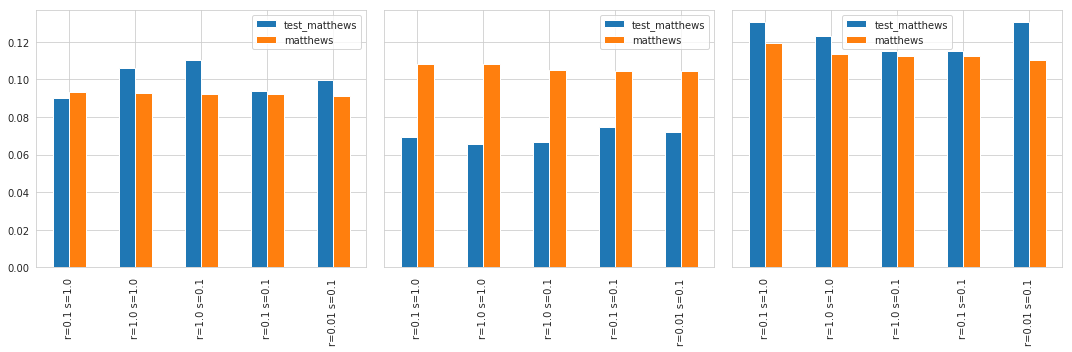

In [123]:
df = df_gdf_pca_mlp_res[df_gdf_pca_mlp_res['features'] == 'pca_gdf_que_prev10'][columns].groupby(
    ['stock', 'r', 's']).head(1).sort_values(by=['matthews', 'test_matthews'], ascending=False)

fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
i = 0
for stock in stocks:
    d = df[df['stock'] == int(stock)]
    ticks = []
    for j, row in d.iterrows():
        ticks.append('r={} s={} '.format(row['r'], row['s']))
    d[['test_matthews', 'matthews']].plot(kind='bar', ax=ax[i])
    
    print(ticks)
    plt.xticks(list(range(len(ticks))), ticks)
    i += 1
plt.tight_layout()

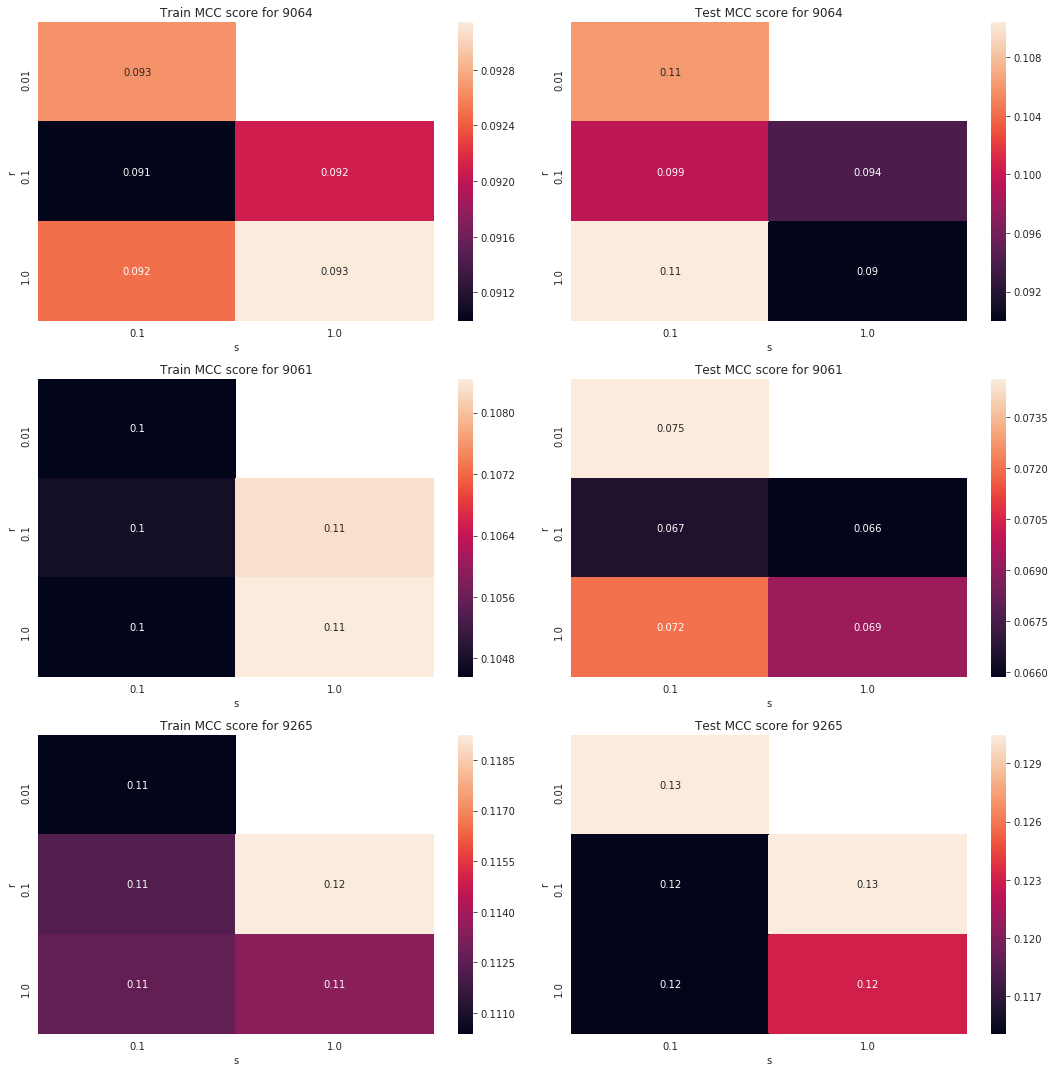

In [170]:
df = df_gdf_pca_mlp_res[df_gdf_pca_mlp_res['features'] == 'pca_gdf_que_prev10'][columns].groupby(
    ['stock', 'r', 's']).head(1).sort_values(by=['matthews', 'test_matthews'], ascending=False)

fig, ax = plt.subplots(3, 2, figsize=(15, 15))
j = 0
i = 0
for stock in stocks:
    d = df[df['stock'] == int(stock)]
    sns.heatmap(data=d[[ 'r', 's', 'matthews']].pivot(index='r', columns='s', values=['matthews'])['matthews'], 
                ax=ax[i][j],
                annot=True)
    ax[i][j].set_title('Train MCC score for {}'.format(stock))
    j +=1
    data = d[[ 'r', 's', 'test_matthews']].pivot(index='r', columns='s', values=['test_matthews'])['test_matthews']
    sns.heatmap(
        data=data, 
        ax=ax[i][j],
        annot=True)
    ax[i][j].set_title('Test MCC score for {}'.format(stock))
    j = 0
    i += 1
plt.tight_layout()